In [13]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pycocotools.coco import COCO
from collections import defaultdict, Counter

col_ref = np.genfromtxt('/opt/ml/input/code/class_dict.csv', skip_header=1, usecols=(1,2,3), delimiter=',', dtype=int)
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

COLORS_HEX = []
for x in col_ref:
    COLORS_HEX.append(rgb_to_hex(tuple(x)))

In [14]:
dataset_base_path = '/opt/ml/input/data/train_all.json'
dataset_path  = '/opt/ml/input/data/seed21'

In [15]:
class get_info():
    def __init__(self, cocopath):
        # load coco data
        self.coco = COCO(cocopath)

        self.anno_cls = []       # anno. cls (N_anno)
        self.anno_area = []      # anno. area fraction? (N_anno)
        self.N_anno = [] # (N_anno) #cls_anno = defaultdict(list) # img. cls별로 몇개의 anno가 들어있는 img인지 (10개 list. img당 anno 개수)
        self.img_N_anno = []     # img별 anno. 개수 (N_img)
        
        self.image_id = self.coco.getImgIds()
        self.image_infos = self.coco.loadImgs(self.image_id)

        self.image_h = self.image_infos[0]['height']
        self.image_w = self.image_infos[0]['width']
        self.image_a = self.image_h * self.image_w
        self.cat_ids = self.coco.getCatIds()           # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.cats = self.coco.loadCats(self.cat_ids)        # [{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'}, ~]

        for image_info in self.image_infos:
            ann_ids = self.coco.getAnnIds(imgIds=image_info['id']) # {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0002.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}
            anns = self.coco.loadAnns(ann_ids)
            self.img_N_anno.append(len(anns))

            for ann in anns:
                self.anno_cls.append(ann['category_id'])
                self.anno_area.append(ann['area'])
                self.N_anno.append(len(anns)) #cls_anno[ann['category_id']].append(len(anns))

        self.anno_cls = np.array(self.anno_cls)
        self.anno_area = np.array(self.anno_area)
        self.N_anno = np.array(self.N_anno)
        self.img_N_anno = np.array(self.img_N_anno)

In [16]:
trains = []
vals = []

base = get_info(dataset_base_path)

for i in range(5):
    trains.append(get_info(os.path.join(dataset_path, 'train_%s.json' %i)))
    vals.append(get_info(os.path.join(dataset_path, 'val_%s.json' %i)))

loading annotations into memory...
Done (t=4.83s)
creating index...
index created!
loading annotations into memory...
Done (t=2.74s)
creating index...
index created!
loading annotations into memory...
Done (t=3.03s)
creating index...
index created!
loading annotations into memory...
Done (t=2.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=2.84s)
creating index...
index created!
loading annotations into memory...
Done (t=3.68s)
creating index...
index created!
loading annotations into memory...
Done (t=2.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=2.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [41]:
def plot_anno_cls(base, info_list):

    num_to_name = ['bg' for i in range(11)]
    for i in trains[0].cats:
        num_to_name[i['id']] = i['name']

    # make DataFrame
    df_cls = pd.DataFrame([Counter(base.anno_cls)] + [Counter(info.anno_cls) for info in info_list]).T
    
    # Change index and column names, add color info
    df_cls.columns=['base'] + ['fold_%s' %i for i in range(len(info_list))]
    idx = []; cols = []
    for i in df_cls.index:
        idx.append(num_to_name[i])
        cols.append(COLORS_HEX[i])
    df_cls.index = idx
    df_cls['colors'] = cols
    print(df_cls.sort_values(by='base', ascending=False))

    # calculate fractions
    df_cls_frac = df_cls.copy()
    for col in df_cls.columns:
        if col == 'colors': continue
        df_cls_frac[col] = df_cls[col]/sum(df_cls[col])
    print(df_cls_frac.sort_values(by='base', ascending=False))

    # plot
    df_cls_frac = df_cls_frac.sort_values(by='base', ascending=False).T
    df_cls_plot = df_cls_frac.reindex(df_cls_frac.index.to_list()[:-1][::-1])

    f, ax = plt.subplots(figsize=(9, 8))
    df_cls_plot.plot(kind='barh', ax=ax, stacked=True, color=df_cls_frac.loc['colors'])
    ax.set_title('Fraction of Annotations per Class')
    ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    ax.set_xlim(0, 1)

               base  fold_0  fold_1  fold_2  fold_3  fold_4   colors
Paper          9311    7380    7536    7546    7493    7289  #0080c0
Plastic bag    7643    6134    6130    6257    6013    6038  #c0c080
Plastic        3090    2504    2425    2485    2442    2504  #4000c0
General trash  2782    2202    2219    2255    2246    2206  #c00080
Styrofoam      1343    1049    1081    1061    1090    1091  #c08040
Paper pack      659     514     520     516     514     572  #008040
Glass           610     450     445     538     478     529  #400080
Metal           562     462     458     478     386     464  #800000
Clothing        177     148     136     145     146     133  #8000c0
Battery          63      43      60      45      57      47  #404080
                   base    fold_0    fold_1    fold_2    fold_3    fold_4  \
Paper          0.354840  0.353347  0.358686  0.353840  0.359118  0.349207   
Plastic bag    0.291273  0.293690  0.291766  0.293398  0.288186  0.289273   
Plastic   

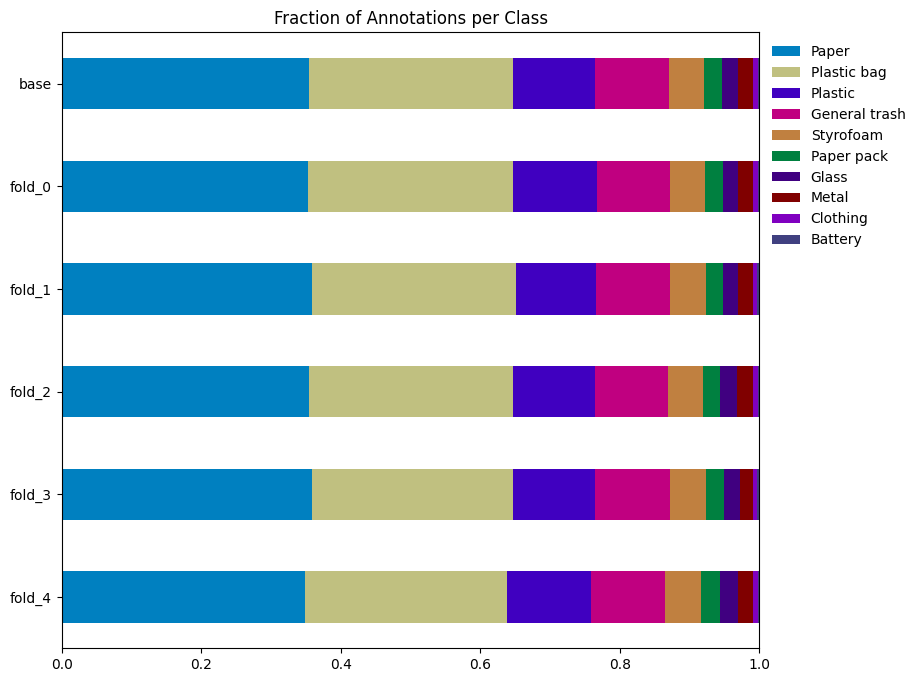

In [42]:
plot_anno_cls(base, trains)

               base  fold_0  fold_1  fold_2  fold_3  fold_4   colors
Paper          9311    1931    1775    1765    1818    2022  #0080c0
Plastic bag    7643    1509    1513    1386    1630    1605  #c0c080
Plastic        3090     586     665     605     648     586  #4000c0
General trash  2782     580     563     527     536     576  #c00080
Styrofoam      1343     294     262     282     253     252  #c08040
Paper pack      659     145     139     143     145      87  #008040
Glass           610     160     165      72     132      81  #400080
Metal           562     100     104      84     176      98  #800000
Clothing        177      29      41      32      31      44  #8000c0
Battery          63      20       3      18       6      16  #404080
                   base    fold_0    fold_1    fold_2    fold_3    fold_4  \
Paper          0.354840  0.360665  0.339388  0.359178  0.338233  0.376747   
Plastic bag    0.291273  0.281845  0.289293  0.282051  0.303256  0.299050   
Plastic   

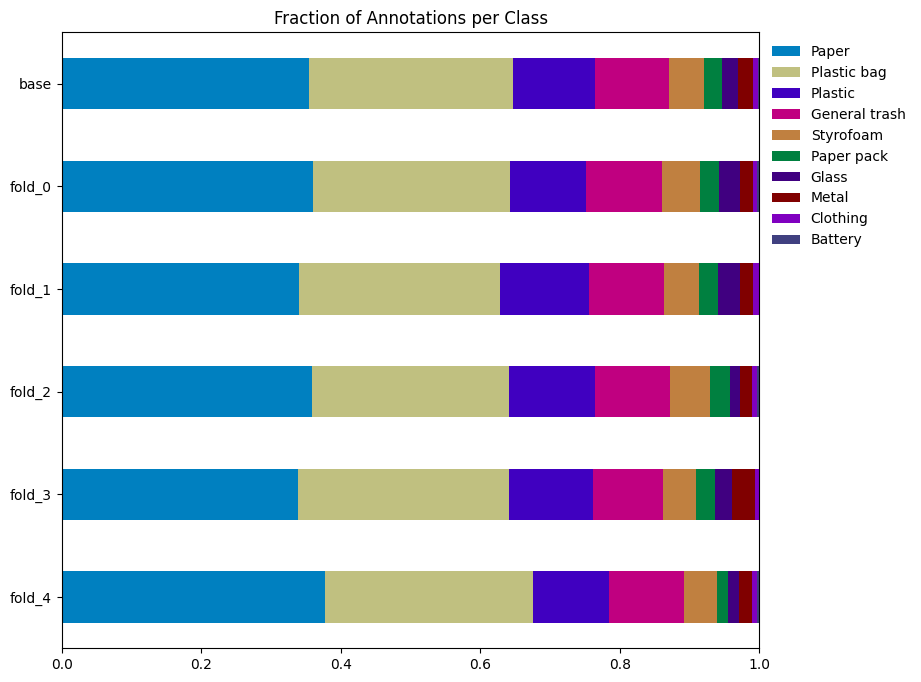

In [43]:
plot_anno_cls(base, vals)